In [1]:
import os
import glob
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from read import read_NX2
import plot
import write

sns.set(style='darkgrid')

In [2]:
# Move this into utils files once it's ready to be canned
filelist = glob.glob(os.path.join('../data/2018', '*csv'))
filelist.sort()

In [3]:
dlist = [read_NX2(f, origin=(49.5851, 10.9703)) 
         for f in sorted(glob.glob('../data/2018/2018*.csv'))]
d18 = pd.concat(dlist)

## Ein paar einfache plots nur um mal zu sehen, was denn da so vor sich geht

Jeder Karte is fur einen Tag. Der blue Punkt zeigt the Position des Schiffes, er verschwindet wenn keine Daten vorliegen z.B. weil das Notebook bei einer Pause abgeschaltet war. Die blaue Linie zeigt den Fahrtweg des gesammten Tages. Segelstrecken und dunkelblau.

In [4]:
plot.folium_map(d18['2018-07-02'])

In [5]:
plot.folium_map(d18['2018-07-03'])

In [6]:
plot.folium_map(d18['2018-07-04'])

In [7]:
plot.folium_map(d18['2018-07-05'])

In [8]:
plot.folium_map(d18['2018-07-06'])

/Users/hamogu/projects/NX2/notebooks/plot.py:76: RuntimeWarning: invalid value encountered in double_scalars
  a = np.dot(x, y) / np.dot(x, x)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/Users/hamogu/projects/NX2/notebooks/plot.py:76: RuntimeWarning: invalid value encountered in double_scalars
  a = np.dot(x, y) / np.dot(x, x)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be

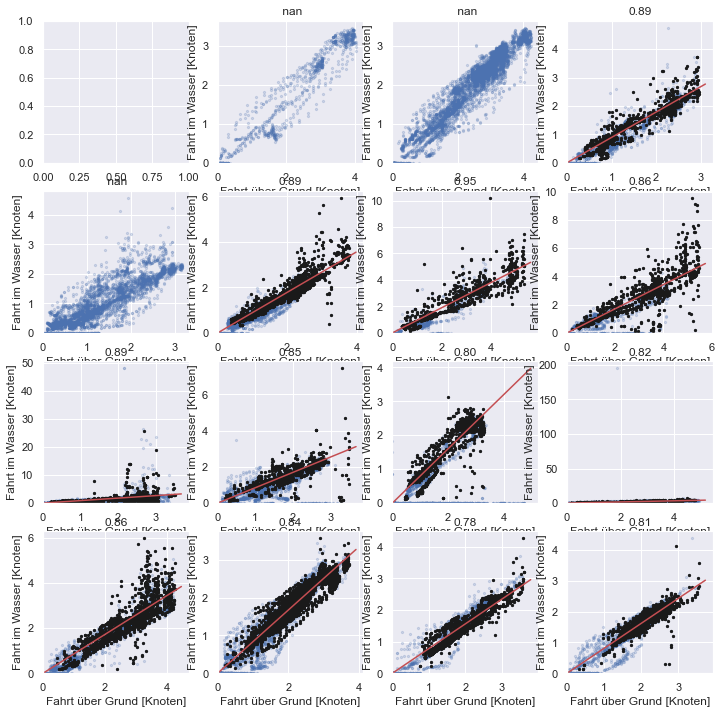

In [9]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(12, 12))
for d, ax in zip(dlist, axes.flatten()):
    if 'HDC' in d.columns:
        a, ind, axout = plot.fit_BSP(d, ax=ax)
        ax.set_title(f'{a:4.2f}')
        ax.get_legend().remove()

Vier Fahrten (drei am ersten Tag) haben keine schwarzen (nutzbaren) Punkte, weil der Kompass nicht so lief wie er sollte.

Da sehe ich erstmal das das trotz smoothing in einigen Fahrten BSPs > 40 auftreten. Vielleicht was das Grund Kontakt?

Die gefitteten Werte fur den Korrekturfaktor sind zwischen 0.8 und 0.9 und man sieht deutlich, dass bei manchen Fahrten einfach nicht viele Punkte in die Berechnung eingehen, also, durchauch eine Ungenauigkeit da ist. Im Rahmen dieser Fehler sieht es nicht so aus, als ob signifikante Unterschiede zwischen den einzelnen Fahrten bestehen. Deshalb schauen wir nun die Werte aller Fahrten gemeinsam an und bestimmen einen Korrkturfaktor fur alle Fahrten.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.8530542749830322


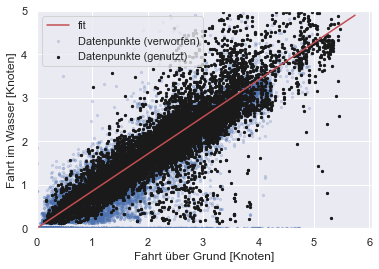

In [10]:
a, ind, ax = plot.fit_BSP(d18)
ax.set_ylim(0, 5)
print(a)
fig = plt.gcf()
if not os.path.exists('../fig_out'):
    os.makedirs('../fig_out')
fig.savefig('../fig_out/2018_Logcal.pdf', bbox_inches='tight')
fig.savefig('../fig_out/2018_Logcal.png', bbox_inches='tight', resolution=300)

## Analyse mit Korrekturfaktor

In [11]:
d18['BSP_orig'] = d18['BSP'].values
d18['BSP'] = d18['BSP'] / a

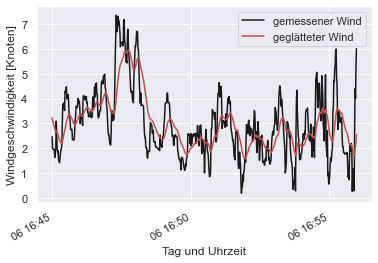

In [12]:
df = d18['2018-07-06 16:45': '2018-07-06 16:55']
ax = df.plot(y=['TWS', 'TWS_s'], style=['k', 'r'])
ax.legend(['gemessener Wind', 'gegl\u00e4tteter Wind'])
ax.set_xlabel('Tag und Uhrzeit')
ax.set_ylabel('Windgeschwindigkeit [Knoten]')
fig = plt.gcf()
fig.savefig('../fig_out/2018_windsmooth.pdf', bbox_inches='tight')
fig.savefig('../fig_out/2018_windsmooth.png', bbox_inches='tight', resolution=300)

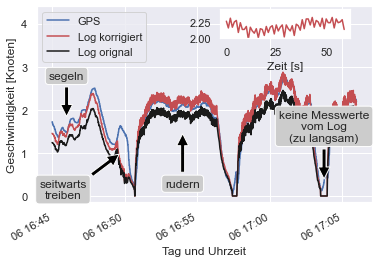

In [13]:
df = d18['2018-07-06 16:45': '2018-07-06 17:05']
ax = df.plot(y=['SOG', 'BSP', 'BSP_orig'], style=['', 'r', 'k'])
ax.legend(['GPS', 'Log korrigiert', 'Log orignal'], loc='upper left')
ax.set_xlabel('Tag und Uhrzeit')
ax.set_ylabel('Geschwindigkeit [Knoten]')
ax.set_ylim(None, 4.4)
# Note: datetime without timezone is 2 h off
# which is much eaiser to do manually here then to 
# bother with timezone objects
kwannotate = dict(xycoords='data', textcoords='data',
                  bbox=dict(boxstyle="round", fc="0.8"),
                  arrowprops=dict(facecolor='black', shrink=0.05),
                  horizontalalignment='center', verticalalignment='top')
ax.annotate('keine Messwerte\nvom Log\n(zu langsam)',
            xy=(datetime(2018, 7, 6, 15, 3, 45), .35),  
            xytext=(datetime(2018, 7, 6, 15, 3, 45), 2), 
            **kwannotate)

ax.annotate('seitwarts\ntreiben',
            xy=(datetime(2018, 7, 6, 14, 49, 45), 1),  
            xytext=(datetime(2018, 7, 6, 14, 45, 45), .4), 
            **kwannotate)
ax.annotate('rudern',
            xy=(datetime(2018, 7, 6, 14, 54), 1.5),  
            xytext=(datetime(2018, 7, 6, 14, 54), .4), 
            **kwannotate)
ax.annotate('segeln',
            xy=(datetime(2018, 7, 6, 14, 46), 1.8),  
            xytext=(datetime(2018, 7, 6, 14, 46), 2.9), 
            **kwannotate)

fig = plt.gcf()
ax2 = fig.add_axes([.55, .77, .3, .10], facecolor='1.0')
df2 = d18['2018-07-06 16:53:00': '2018-07-06 16:54:00']
ax2.plot(df2['BSP'].values, color='r')
ax2.set_xlabel('Zeit [s]')
ax2.set_ylim(2., 2.45)
fig.savefig('../fig_out/2018_speedlabels.pdf', bbox_inches='tight')
fig.savefig('../fig_out/2018_speedlabels.png', bbox_inches='tight', resolution=300)

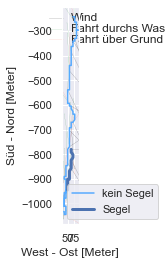

In [14]:
ax = plot.course(df, n=60, scale=5)

In [15]:
dspriet = d18['2018-07-04']
drah = pd.concat([d18['2018-07-03'], d18['2018-07-05'], d18['2018-07-06']])

In [16]:
print('Zeit mit Rahsegel gesetzt {:5.1f} min'.format((drah['Segel'] > 0.5).sum() / 60))
print('Zeit mit Sprietsegel gesetzt {:5.1f} min'.format((dspriet['Segel'] > 0.5).sum() / 60))

Zeit mit Rahsegel gesetzt 163.6 min
Zeit mit Sprietsegel gesetzt  42.6 min


In [17]:
speedbins=np.arange(1.5,16,3.)

mk_polar = plot.make_polar

kwdrift = {'speedbins': speedbins, 'anglecol': 'absTWA_s'}
prah, dprah = mk_polar(drah, **kwdrift)
pspriet, dpspriet = mk_polar(dspriet, **kwdrift)

prahcorr, dprah = mk_polar(drah.copy(), speedbins=speedbins)
psprietcorr, dpspriet = mk_polar(dspriet, speedbins=speedbins)


In [18]:
def polar3(df, dfcorr=None, col='BSP'):
    fig, axes = plt.subplots(ncols=3, subplot_kw={'polar': True}, figsize = (13,7))
    ax1 = plot.polar(df.median()[col].unstack(), ax=axes[0],
                     labeltext='{:4.1f}-{:4.1f} kn')
    ax2 = plot.polar(df.mean()[col].unstack(), ax=axes[1],
                     labeltext='{:4.1f}-{:4.1f} kn')
    ax3 = plot.polar(np.log10(df.count()['BSP'].unstack()),
                     ax=axes[2], labeltext='{:4.1f}-{:4.1f} kn')
    if not dfcorr is None:
        ax1.set_prop_cycle(None)
        ax1 = plot.polar(dfcorr.median()[col].unstack(), ax=axes[0],
                         labeltext='__no_legend__', lw=3)
        ax2.set_prop_cycle(None)
        ax2 = plot.polar(dfcorr.mean()[col].unstack(), ax=axes[1],
                         labeltext='__no_legend__', lw=3)
        
    ax1.set_title('Polardiagram - Median')
    ax2.set_title('Polardiagram - Mean')
    ax3.set_title ('Log10(Anzahl Datenpunkte per bin)')
    ax1.legend(loc='upper left')

/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


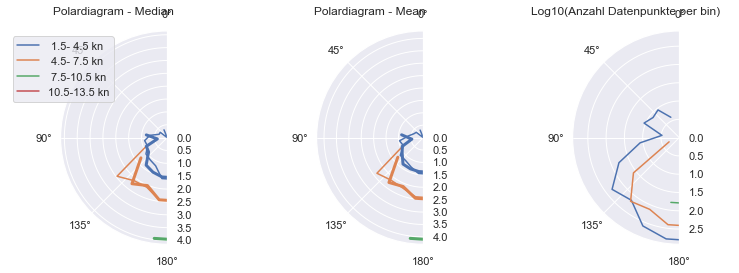

In [19]:
polar3(prah, prahcorr)

/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


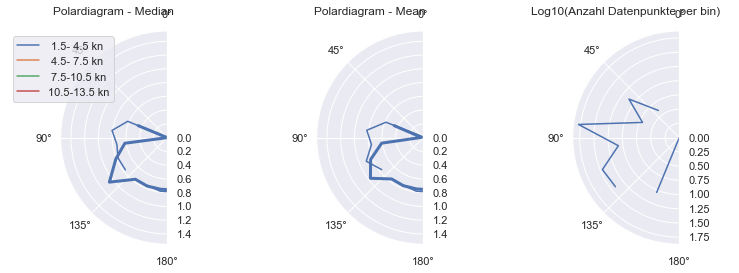

In [20]:
polar3(pspriet, psprietcorr)

In [21]:
dpolar = {}
dpolarcorr = {}
if not os.path.exists('../polar_diagrams'):
    os.makedirs('../polar_diagrams')

for year in ['2006', '2008', '2011', '2012']:
    dpolar[year] = write.read_polar_csv(f'../polar_diagrams/TWA_{year}.dat')
    dpolarcorr[year] = write.read_polar_csv(f'../polar_diagrams/TWAcorr_{year}.dat')

In [22]:
dpolar['Rah'] = prah['BSP'].mean().unstack()
dpolar['Spriet'] = pspriet['BSP'].mean().unstack()
dpolarcorr['Rah'] = prahcorr['BSP'].mean().unstack()
dpolarcorr['Spriet'] = psprietcorr['BSP'].mean().unstack()

/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)
/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


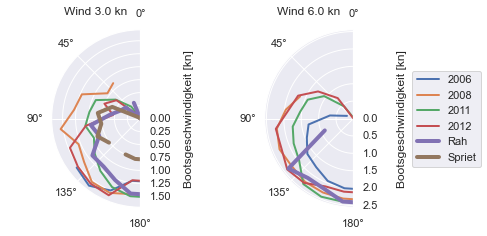

In [23]:
fig, axes = plt.subplots(ncols=2, subplot_kw={'polar': True}, figsize = (7, 7))

for i, col in enumerate(dpolar['2006'].columns[:2]):
    for j, df in enumerate(dpolar.values()):
        plot.polar(df.iloc[:, i].to_frame(), ax=axes[i], lw = 2 if j < 4 else 4)
    axes[i].set_ylabel('Bootsgeschwindigkeit [kn]')
    axes[i].yaxis.set_label_coords(1.05, 0.5)        
    axes[i].set_title('Wind '+ str(col.mid) + ' kn')
axes[1].legend(dpolar.keys(), bbox_to_anchor=(1.05, .8))
fig.savefig('../fig_out/2018_polar.pdf', bbox_inches='tight')
fig.savefig('../fig_out/2018_polar.png', bbox_inches='tight', resolution=300)

/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)
/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


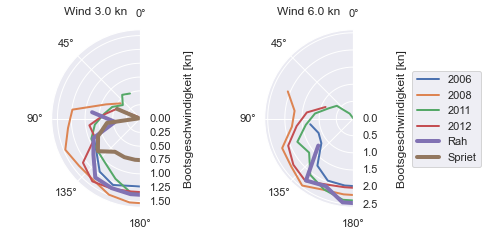

In [24]:
fig, axes = plt.subplots(ncols=2, subplot_kw={'polar': True}, figsize = (7, 7))

for i, col in enumerate(dpolar['2006'].columns[:2]):
    for j, df in enumerate(dpolarcorr.values()):
        plot.polar(df.iloc[:, i].to_frame(), ax=axes[i], lw = 2 if j < 4 else 4)
    axes[i].set_title('Wind '+ str(col.mid) + ' kn')
    axes[i].set_ylabel('Bootsgeschwindigkeit [kn]')
    axes[i].yaxis.set_label_coords(1.05, 0.5)
axes[1].legend(dpolar.keys(), bbox_to_anchor=(1.05, .8))
fig.savefig('../fig_out/2018_polarcorr.pdf', bbox_inches='tight')
fig.savefig('../fig_out/2018_polarcorr.png', bbox_inches='tight', resolution=300)

In [25]:
dpolarbear = {}
for year in ['2006', '2008', '2011', '2012']:
    dpolarbear[year] = write.read_polar_csv(f'../polar_diagrams/TWA_{year}.dat', 
                                        'absbearingdiff')
dpolarbear['Rah'] = prah['absbearingdiff'].mean().unstack()
dpolarbear['Spriet'] = pspriet['absbearingdiff'].mean().unstack()

/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)
/Users/hamogu/anaconda3/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


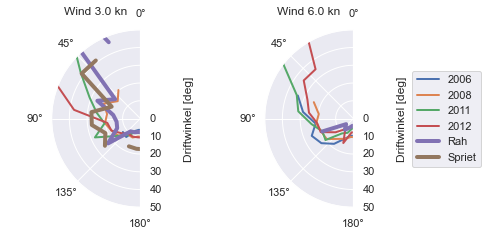

In [26]:
fig, axes = plt.subplots(ncols=2, subplot_kw={'polar': True}, figsize = (7, 7))

for i, col in enumerate(dpolar['2006'].columns[:2]):
    for j, df in enumerate(dpolarbear.values()):
        plot.polar(df.iloc[:, i].to_frame(), ax=axes[i], lw = 2 if j < 4 else 4)
    axes[i].set_title('Wind '+ str(col.mid) + ' kn')
    axes[i].set_ylabel('Driftwinkel [deg]')
    axes[i].yaxis.set_label_coords(1.05, 0.5)
    axes[i].set_ylim(0, 50.)
axes[1].legend(dpolarbear.keys(), bbox_to_anchor=(1.05, .8))
fig.savefig('../fig_out/2018_polarbear.pdf', bbox_inches='tight')
fig.savefig('../fig_out/2018_polarbear.png', bbox_inches='tight', resolution=300)

## Pulsfrequenz

Bis zu sechs Ruderer trugen bei den Testfahrten ein Pulsmessgerat. Der Puls wurde ab und zu durchgesagt und mit Zeitstempel aufgeschrieben, normalerweise nach einigen Minuten Fahrt. Dabei geht es darum zu sehen, welche Geschwindigkeiten ein Ruderer lagen durchhalten kann und ab wann die Ruderer mit ihrem Maximalpuls arbeiten, den sie nur fur kurze Zeit aufrechterhalten konnen. Durch die Art der Datenaufnahme ist allerdings in den Notizen nicht immer klar wer genau an jedme Tag ein Pulsmessegerat trug. Da Menschen ja nachdem wie gut sie trainiert sind, einen sehr unterschiedlichen Ruhepuls haben konnen (60-80 gilt als "normal", aber Spitzensportler konnen eine Ruhepuls von nur 35 haben) und auch der Maximalpuls sich individuell unterscheidet, ist der Vergleich der Zahlen selbst nur beding aussagekraftig. Allerdings erwartet man, das bei hoheren Geschwindigkeiten der Mittelwert der Pulsfrequenz uber alle Ruderer ansteigt.

In [27]:
# Werte, die bereits bei der Messaufnahme als fraglich gekennzeichnet wurden,
# sind in der folgenden Liste nicht enthalten.
pulswerte=[
[(2018, 7, 4, 15, 26, 0), 14, 127],
[(2018, 7, 4, 15, 31, 0), 14, 157, 152],
[(2018, 7, 5, 12, 41, 20), 21, 135],
[(2018, 7, 5, 12, 55, 55), 21, 120, 130, 90],
[(2018, 7, 5, 13, 4, 0), 21, 138, 125, 140],
[(2018, 7, 5, 13, 11, 45), 21, 152, 138, 134, 160, 143],
[(2018, 7, 5, 13, 25, 35), 21, 154, 148, 135, 179],
[(2018, 7, 5, 13, 40, 10), 21, 125, 145, 170, 156, 149, 145],
[(2018, 7, 5, 14, 34, 20), 21, 120, 121, 104, 111, 92, 125],
[(2018, 7, 5, 14, 36, 40), 21, 117, 137, 125, 128],
[(2018, 7, 5, 14, 39, 30), 21, 127, 120, 140, 106, 116, 127],
[(2018, 7, 5, 14, 47, 10), 21, 132, 120, 140, 115, 120],
[(2018, 7, 5, 14, 52, 10), 21, 142, 135, 160, 137, 145],
[(2018, 7, 5, 15, 0, 0), 21, 138, 128, 156, 126, 135],
[(2018, 7, 5, 15, 6, 50), 21, 135, 129, 165, 140, 138],
[(2018, 7, 5, 15, 16, 5), 21, 122, 105, 130, 98, 120],
[(2018, 7, 6, 13, 14, 10), 12, 101, 104, 82, 105],
[(2018, 7, 6, 13, 22, 50), 12, 126, 121, 106, 125],
[(2018, 7, 6, 13, 32, 10), 12, 125, 133, 132, 145],
[(2018, 7, 6, 14, 6, 5), 12, 97, 109, 94, 100],
[(2018, 7, 6, 14, 9, 50), 12, 144, 126, 138, 126],
[(2018, 7, 6, 14, 29, 45), 12, 114, 113, 96, 111],
[(2018, 7, 6, 15, 49, 45), 17, 104, 117],
[(2018, 7, 6, 15, 57, 0), 17, 115, 123],
[(2018, 7, 6, 16, 0, 10), 17, 143, 123],
[(2018, 7, 6, 16, 56, 20), 17, 75, 102, 104, 113],
[(2018, 7, 6, 17, 2, 50), 17, 127, 122, 122, 98],
[(2018, 7, 6, 17, 6, 15), 17, 132, 132, 133],
[(2018, 7, 6, 17, 34, 20), 17, 99, 112, 114, 114]]

In [28]:
times = []
pulses = []
people = []
for row in pulswerte:
    for p in row[2:]:
        times.append(datetime(*row[0]))
        pulses.append(p)
        people.append(row[1])

In [29]:
dpuls = pd.DataFrame({'time': times, 'puls': pulses, 'Personen im Boot': people})
dpuls['time'] = dpuls['time'] - timedelta(seconds=60)
dpuls['time'] = dpuls['time'].dt.tz_localize('Europe/Berlin')
dpuls.set_index('time', inplace=True, drop=False)

d18['BSP_s'] = d18['BSP'].rolling(20, center=True).median()
dpm = dpuls.merge(d18, left_index=True, right_index=True)

Text(0, 0.5, 'Geschwindigkeit [kn]')

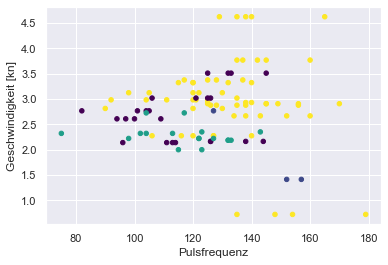

In [30]:
ax = dpm.plot('puls', 'BSP_s', kind='scatter', 
              colorbar=False, c='Personen im Boot', colormap='viridis')
ax.set_xlabel('Pulsfrequenz')
ax.set_ylabel('Geschwindigkeit [kn]')

Dir Grafik zeigt die gemessenene Pulsfrequenzen in Relation zur gemessenen Schiffsgeschwindigkeit 60 Sekunden vor dem Logeintrag. Dieser Zeitabstand ist notig, weil ja ja eine kurze Zeit dauert, die Pulsfrequenzen durchzusagen und aufzuschreiben, die Grafik sieht aber ahnlich aus, wenn nur 30 s Abstand gewahlt wird. Man kann leicht erkneen, welche Pulsfrequenzen zur selben Zeit aufgeschreibne wurden, weil diese dann alle der selben Schiffsgeschwindigkeit zugeordnet werden und sie auf einer horizontalen Linie liegen. Die Farbe kodiert die Anzahl der Personen im Boot wahrende der Messfahrt von lila (14) bis gelb (21). Wenn mehr Ruderer das Boot bewegen, sollte man erwarten, dass eine geringere Anstrengung pro Ruderer ausreicht, um eine bestimmte Geschwindikgeit zu erreichen. 

Die Grafik zeigt aber keinen Zusammehang zwischen Pulsfrequenz und Schiffsgeschwindigkeit. Qualitativ wissen wir naturlich aus dme Experiment, dass es anstrengender ist, schnell zu rudern als langsam. Warum ist dieser Zusammehang oben trotzdem nicht zu erkennen? Dafur gibt es vermutlich mehrerer Grunde. Zum einen wechselte die Mannschaft und die Pulswerte wurden nicht immer von den selben Rudereren ermittelt. Wegen der oben erwahnten individuel unterschiedlichen Pulsfrequenz fuhrt das zu einer Streuung der Daten. Andererseits haben noch viele andere Details einen Einfluss auf die Geschwindigkeit, wie z.B. Windstarke und Richtung. Selbst wenn das Segel nicht gesetzt ist, trifft der wind auf das Schanzkleid und die Rah. Nicht zuletzt war die Messtrecke kurz und die Ruderstrecke of nur drei Minuten lang. In dieser Zeit hat sich der Puls vielleicht noch nicht auf einen konstanten Wert eingependelt.

## Datenexport

Jetzt schreiben wir die "guten" Daten (BSP kalibriert, zeitlich sortiert) in eine CVS Datei, um sie an andere weiterzugeben.

In [32]:
if not os.path.exists('../data/2018/cleaned'):
    os.mkdir('../data/2018/cleaned')

drah.to_csv(os.path.join('../data/2018/cleaned', 'NX2_Rah_clean.csv'))
dspriet.to_csv(os.path.join('../data/2018/cleaned', 'NX2_Spriet_clean.csv'))

### Bedeutung der Datenspalten
- time - Datum und Uhrzeit der Messung
- DATE, TIME - Index for Datum und Zeit. DATE zahlt Tage (nicht ganz sicher von wann, vermutlich 1.1.1970 oder so was) und TIME Sekunden seit Mitternacht. Diese beiden Spalten sind nutzlich, weil es einfacher ist, sie einzulesen, insbesondere, wenn das Datum an sich nicht wichtig ist, sondern nur die Sekunden, um die Daten in die richtige Reihenfolge zu bringen)
- AWS - apparent wind speed (direkt gemessen)
- TWS - True wind speed (AWS korrigiert mit dem GPS Signal)
- BSP - boat speed - mit dem Log gemessen
- SOG - Speed over ground (vom GPS)
- TWD - true wind direction (berechnet)
- bearingdiff - Differenz aus Kompasskurs und course over ground
- x/y - Abstand vom Anleger in Metern. Die x-Achse geht ungefahr nach Norden.
- Segel: 1 - Segel gesetzt, 0 - Segel nicht gesetzt
- Ruderschlage / Minute
- abs*: Alle Spalten, die mit "abs" beginnen sind von 360 auf 180 Grad gefaltet.
- *_s: Alle Spalten, die auf "_s" enden, haben Werte, die schon geglattet sind (mit einen moving Window mit exponential weighting).
- BSP_orig: gemessene BSP ohne Korrekturfaktor. Nur von Interesse falls jemand das Log neu kalibireren wollen.
- x/y _Segel_masked: x/y nur mit Werten, wenn das Segel gesetzt war. Kann aus x/y und "Segel" gebildet werden. 

### Einheiten

- LAT/ LON - in Grad
- AWS / TWS / BSP / SOG - in Knoten
- x/y - in Meter
- TWA/AWA - in Grad relativ zum Kiel
- COG / HDC - in Grad relativ zu Norden (Himmelrichtung)
- bearingdigg  - in Grad